KeyboardInterrupt: 

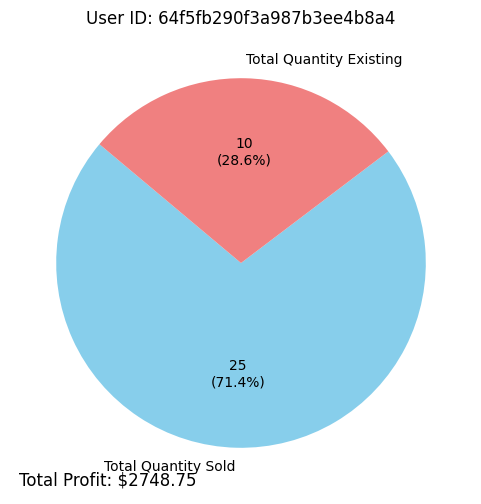

In [3]:
import os
import time
import json
import pandas as pd
import matplotlib.pyplot as plt

# Specify the directory containing JSON files
json_directory = "./products"

# Specify the directory to save the charts
charts_directory = "./producer-charts/"

# Create the charts directory if it doesn't exist
if not os.path.exists(charts_directory):
    os.makedirs(charts_directory)

# Initialize data structures for user-specific reports
user_reports = {}

def delete_old_charts():
    # Function to delete old chart files in the charts directory
    for filename in os.listdir(charts_directory):
        if filename.endswith(".png"):
            chart_file = os.path.join(charts_directory, filename)
            os.remove(chart_file)

def update_charts():
    # Function to update user-specific report data
    def update_user_report(user_id, product_data):
        user_report = user_reports.setdefault(user_id, {"total_profit": 0, "total_quantity_sold": 0, "total_quantity_existing": 0})
        profit = product_data["price"] * product_data["sold"]
        quantity_sold = product_data["sold"]
        quantity_existing = product_data["quantity"]
        user_report["total_profit"] += profit
        user_report["total_quantity_sold"] += quantity_sold
        user_report["total_quantity_existing"] += quantity_existing

    # Delete old charts before generating new ones
    delete_old_charts()

    # Load and process JSON files
    for filename in os.listdir(json_directory):
        if filename.endswith(".json"):
            with open(os.path.join(json_directory, filename), 'r', encoding='utf-8') as file:
                json_str = file.read()
                try:
                    data_list = json.loads(json_str)
                    if isinstance(data_list, list) and len(data_list) > 0:
                        for data in data_list:
                            user_id = data["_id"]["$oid"]
                            update_user_report(user_id, data)

                except json.JSONDecodeError:
                    print(f"Error decoding JSON in file: {filename}")

    # Convert user reports to a DataFrame for easy filtering
    user_report_df = pd.DataFrame.from_dict(user_reports, orient='index')

    # Create individual pie charts for each user ID
    for user_id, user_data in user_report_df.iterrows():
        total_profit = user_data['total_profit']
        labels = ['Total Quantity Sold', 'Total Quantity Existing']
        quantities = [user_data['total_quantity_sold'], user_data['total_quantity_existing']]
        colors = ['skyblue', 'lightcoral']

        plt.figure(figsize=(6, 6))
        def autopct_format(pct):
            total = sum(quantities)
            num = int(pct / 100. * total + 0.5)
            return f'{num}\n({pct:.1f}%)'
        plt.pie(quantities, labels=labels, colors=colors, autopct=autopct_format, startangle=140)
        plt.title(f'User ID: {user_id}')
        
        # Add total profit as text in the corner
        plt.annotate(f'Total Profit: ${total_profit:.2f}', xy=(0.02, 0.02), xycoords='axes fraction', fontsize=12)

        # Save the chart to the charts directory
        chart_filename = os.path.join(charts_directory, f'{user_id}.png')
        plt.savefig(chart_filename)

        plt.tight_layout()
        plt.close()  # Close the chart to free up memory

# Continuously monitor the directory for changes and update charts frequently
while True:
    update_charts()
    time.sleep(5)  # Sleep for 5 seconds before checking again
